# 1. Dataset Loading (KaggleHub)

In [33]:
# ============================
# 1. LOAD DATASET FROM KAGGLE
# ============================
import kagglehub

path = kagglehub.dataset_download("sachchitkunichetty/rvf10k")
print("Dataset Path:", path)


Using Colab cache for faster access to the 'rvf10k' dataset.
Dataset Path: /kaggle/input/rvf10k


#2. Count Total Files

In [34]:
# ============================
# 2. COUNT TOTAL FILES
# ============================
import os

count = 0
for root, dirs, files in os.walk(path):
    count += len(files)

print("Total files in dataset:", count)


Total files in dataset: 10002


#3. Directory Setup

In [35]:
# ============================
# 3. DEFINE TRAIN & VALID DIR
# ============================
BASE_DIR = os.path.join(path, "rvf10k")
TRAIN_DIR = os.path.join(BASE_DIR, "train")
VALID_DIR = os.path.join(BASE_DIR, "valid")

print("Train directory:", TRAIN_DIR)
print("Valid directory:", VALID_DIR)


Train directory: /kaggle/input/rvf10k/rvf10k/train
Valid directory: /kaggle/input/rvf10k/rvf10k/valid


#4. Directory Content Check

In [36]:
# ============================
# 4. CHECK DIRECTORY CONTENTS
# ============================
print("Train directory contents:")
for item in os.listdir(TRAIN_DIR):
    print("  ", item)

print("\nValid directory contents:")
for item in os.listdir(VALID_DIR):
    print("  ", item)


Train directory contents:
   fake
   real

Valid directory contents:
   fake
   real


#5. Torch Transformations + DataLoader

In [37]:
# ==========================================
# 5. DATA TRANSFORMATIONS & DATALOADERS
# ==========================================
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

IMAGE_SIZE = 224

train_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

valid_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

BATCH_SIZE = 32

train_dataset = datasets.ImageFolder(TRAIN_DIR, transform=train_transform)
valid_dataset = datasets.ImageFolder(VALID_DIR, transform=valid_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)

print("Classes:", train_dataset.classes)
print("Train images:", len(train_dataset))
print("Validation images:", len(valid_dataset))


Classes: ['fake', 'real']
Train images: 7000
Validation images: 3000


#6. Sample Image Dimension Check

Image shape: torch.Size([3, 224, 224])
Label: fake


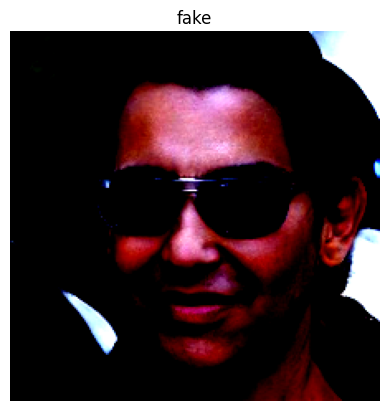

In [38]:
# ==========================================
# 6. CHECK SAMPLE IMAGE DIMENSIONS
# ==========================================
import matplotlib.pyplot as plt

sample_image, sample_label = train_dataset[571]
print("Image shape:", sample_image.shape)
print("Label:", train_dataset.classes[sample_label])

plt.imshow(sample_image.permute(1, 2, 0))
plt.title(train_dataset.classes[sample_label])
plt.axis('off')
plt.show()


#7. Count Images Per Class

In [39]:
# ==========================================
# 7. CLASS DISTRIBUTION CHECK
# ==========================================
from collections import Counter

train_counts = Counter(train_dataset.targets)
valid_counts = Counter(valid_dataset.targets)

print("Train images per class:")
for idx, count in train_counts.items():
    print(f"  {train_dataset.classes[idx]}: {count}")

print("\nValidation images per class:")
for idx, count in valid_counts.items():
    print(f"  {valid_dataset.classes[idx]}: {count}")


Train images per class:
  fake: 3500
  real: 3500

Validation images per class:
  fake: 1500
  real: 1500


#8. Corrupted Image Check (Train + Valid)

In [40]:
# ==========================================
# 8. CHECK CORRUPTED IMAGES
# ==========================================
from PIL import Image

def find_corrupted_images(directory):
    corrupted = []
    print("\nScanning:", directory)

    for root, _, files in os.walk(directory):
        for f in files:
            if f.lower().endswith(('.jpg','.png','.jpeg','.bmp','.gif')):
                path = os.path.join(root, f)
                try:
                    with Image.open(path) as img:
                        img.verify()
                except:
                    corrupted.append(path)

    return corrupted


corrupted_train = find_corrupted_images(TRAIN_DIR)
corrupted_valid = find_corrupted_images(VALID_DIR)

print("\nTotal corrupted (train):", len(corrupted_train))
print("Total corrupted (valid):", len(corrupted_valid))


Scanning: /kaggle/input/rvf10k/rvf10k/train

Scanning: /kaggle/input/rvf10k/rvf10k/valid

Total corrupted (train): 0
Total corrupted (valid): 0


#9. Image Grid Display Utility

In [41]:
# ==========================================
# 9. IMAGE GRID DISPLAY FUNCTION
# ==========================================
import numpy as np
import torchvision.utils as vutils
import matplotlib.pyplot as plt

def imshow(batch, title=None):
    grid = vutils.make_grid(batch)
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])

    img = grid.numpy().transpose(1, 2, 0)
    img = std * img + mean
    img = np.clip(img, 0, 1)

    plt.imshow(img)
    if title: plt.title(title)
    plt.axis("off")
    plt.show()

#10. Display 16 Images Per Class


Class: fake


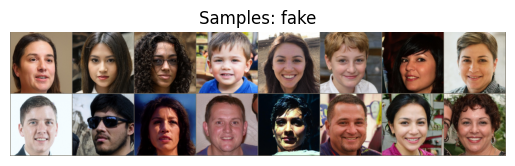


Class: real


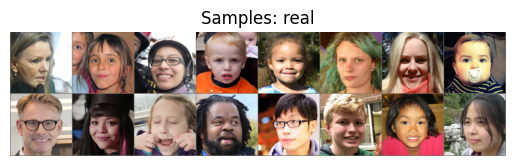

In [42]:
# ==========================================
# 10. CLASS-WISE IMAGE SAMPLE VISUALIZATION
# ==========================================
import random

class_indices = [[] for _ in train_dataset.classes]

for idx, (_, label) in enumerate(train_dataset):
    class_indices[label].append(idx)

for i, class_name in enumerate(train_dataset.classes):
    print("\nClass:", class_name)

    indices = random.sample(class_indices[i], min(16, len(class_indices[i])))
    images = [train_dataset[idx][0] for idx in indices]

    batch = torch.stack(images)
    imshow(batch, f"Samples: {class_name}")


# 11. Classical Feature Extraction (HOG + LBP + Sobel)

In [43]:
# ======================================================
# 11. CLASSICAL FEATURE EXTRACTION FOR RANDOM FOREST
# ======================================================
import cv2
import numpy as np
from skimage.feature import hog, local_binary_pattern

def extract_features(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (128, 128))

    # --- HOG ---
    hog_feat = hog(img, orientations=9, pixels_per_cell=(8, 8),
                   cells_per_block=(2, 2), block_norm='L2-Hys')

    # --- LBP ---
    lbp = local_binary_pattern(img, P=8, R=1, method='uniform')
    lbp_hist, _ = np.histogram(lbp.ravel(), bins=256, range=(0, 256))

    # --- Sobel (Edges) ---
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1)
    sobel_feat = np.hstack([sobelx.ravel(), sobely.ravel()])

    # Combine all features
    return np.hstack([hog_feat, lbp_hist, sobel_feat])


#12. Build Feature Dataset for Random Forest

In [44]:
# ======================================================
# 12. BUILD FEATURE MATRIX FOR RANDOM FOREST
# ======================================================
import glob

X = []
y = []

for class_name in train_dataset.classes:
    class_dir = os.path.join(TRAIN_DIR, class_name)
    for file in glob.glob(class_dir + "/*"):
        features = extract_features(file)
        X.append(features)
        y.append(class_name)

print("Feature matrix size:", len(X))


Feature matrix size: 7000


#13. Train Random Forest

In [45]:
# ======================================================
# 13. TRAIN RANDOM FOREST
# ======================================================
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X, y)

print("Random Forest training completed.")


Random Forest training completed.


# 14. PREPARE VALIDATION DATA FOR EVALUATION

In [46]:
# ======================================================
# 14. PREPARE VALIDATION DATA FOR EVALUATION
# ======================================================
import glob
import numpy as np

X_val = []
y_val = []

for class_name in valid_dataset.classes:
    class_dir = os.path.join(VALID_DIR, class_name)
    for file in glob.glob(class_dir + "/*"):
        features = extract_features(file)
        X_val.append(features)
        y_val.append(class_name)

print("Validation feature matrix size:", len(X_val))

Validation feature matrix size: 3000


#15. MAKE PREDICTIONS

In [47]:
y_pred = rf.predict(X_val)
y_pred_proba = rf.predict_proba(X_val)

#16. CONFUSION MATRIX

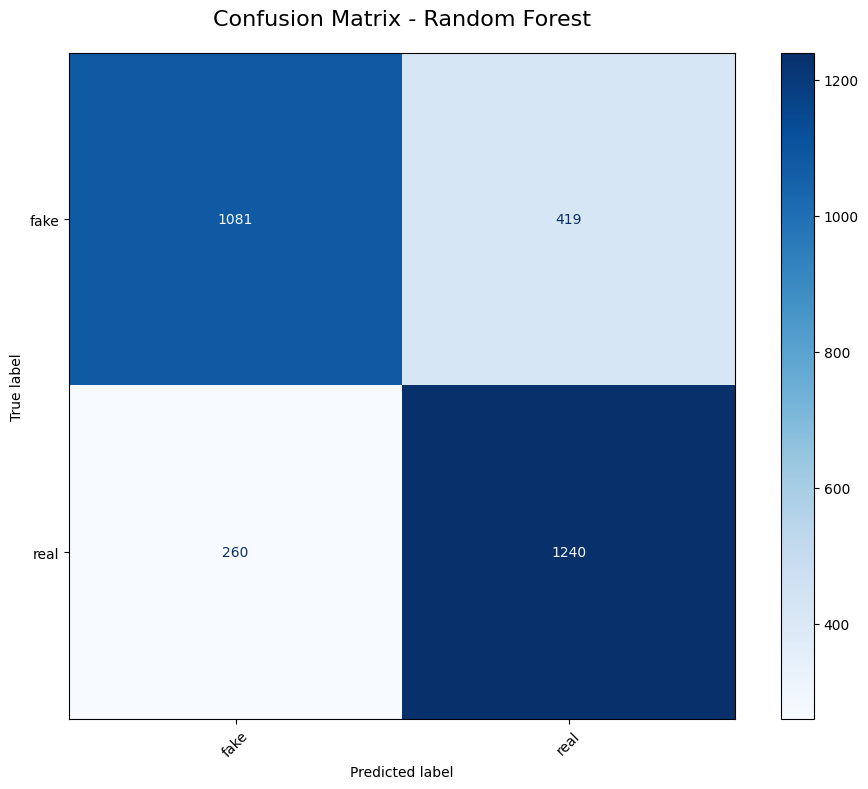

In [48]:
# ======================================================
# 16. CONFUSION MATRIX
# ======================================================
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_val, y_pred, labels=train_dataset.classes)

fig, ax = plt.subplots(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_dataset.classes)
disp.plot(cmap='Blues', ax=ax, xticks_rotation=45)
plt.title('Confusion Matrix - Random Forest', fontsize=16, pad=20)
plt.tight_layout()
plt.show()

#17. ACCURACY SCORE

In [49]:
# ======================================================
# 17. ACCURACY SCORE
# ======================================================
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_val, y_pred)
print(f"\nOverall Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")


Overall Accuracy: 0.7737 (77.37%)


# 18. CLASSIFICATION REPORT

In [50]:
# ======================================================
# 18. CLASSIFICATION REPORT
# ======================================================
from sklearn.metrics import classification_report

print("\n" + "="*60)
print("CLASSIFICATION REPORT")
print("="*60)
report = classification_report(y_val, y_pred, target_names=train_dataset.classes)
print(report)


CLASSIFICATION REPORT
              precision    recall  f1-score   support

        fake       0.81      0.72      0.76      1500
        real       0.75      0.83      0.79      1500

    accuracy                           0.77      3000
   macro avg       0.78      0.77      0.77      3000
weighted avg       0.78      0.77      0.77      3000



# 19. ROC CURVES (One-vs-Rest for Multi-class)

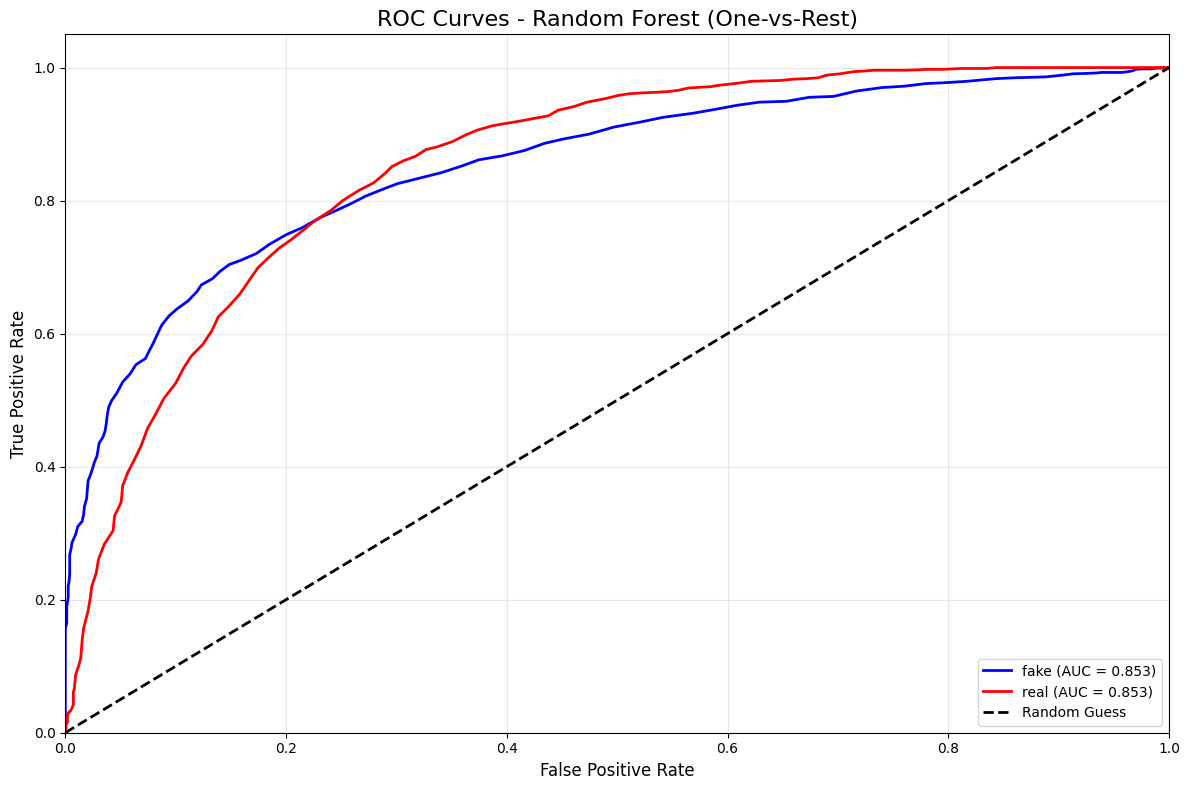

In [51]:
# ======================================================
# 19. ROC CURVES (One-vs-Rest for Multi-class)
# ======================================================
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle
import numpy as np # Ensure numpy is imported for np.eye

# Binarize the labels for ROC computation
# The original label_binarize with a 1D y_val returns a single column for binary classification.
# To get one-hot encoding for each class for "one-vs-rest" ROC, we need to manually create it.
y_val_numeric = np.array([train_dataset.class_to_idx[cls] for cls in y_val])
n_classes = len(train_dataset.classes)
y_val_bin = np.eye(n_classes)[y_val_numeric]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
fig, ax = plt.subplots(figsize=(12, 8))
colors = cycle(['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan'])

for i, color in zip(range(n_classes), colors):
    ax.plot(fpr[i], tpr[i], color=color, lw=2,
            label=f'{train_dataset.classes[i]} (AUC = {roc_auc[i]:.3f})')

ax.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Guess')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('ROC Curves - Random Forest (One-vs-Rest)', fontsize=16)
ax.legend(loc="lower right", fontsize=10)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 20. MACRO AND MICRO AVERAGE ROC

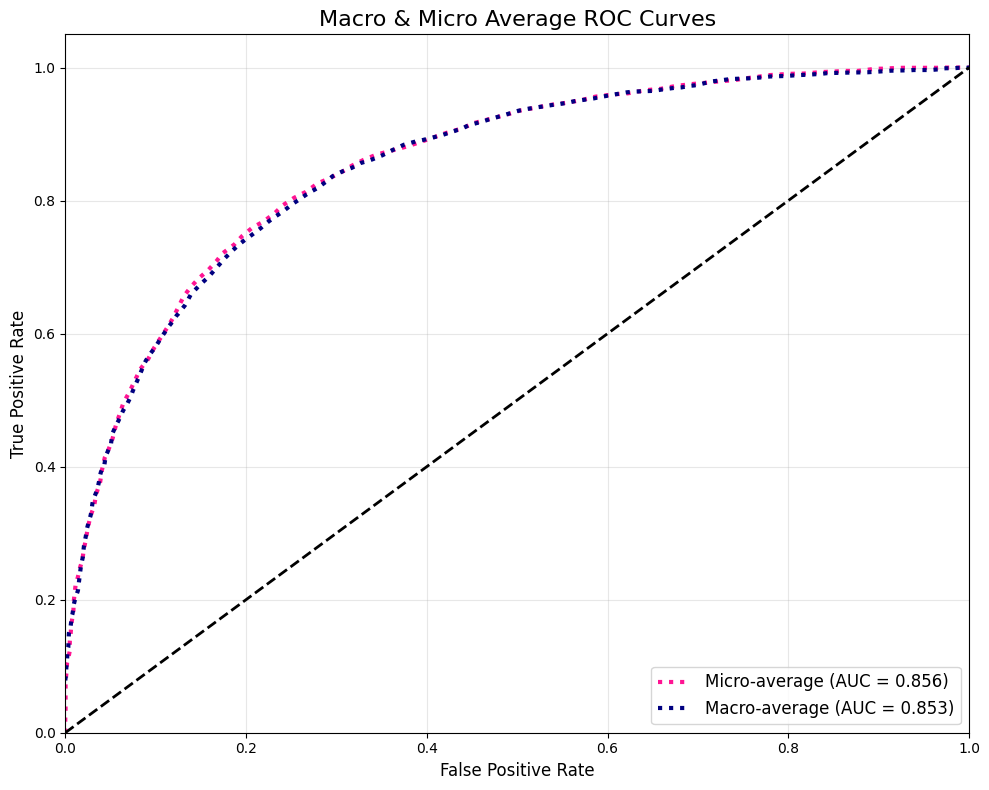

In [52]:
# ======================================================
# 20. MACRO AND MICRO AVERAGE ROC
# ======================================================
import numpy as np # Ensure numpy is imported for np.interp

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_val_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot average ROC curves
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(fpr["micro"], tpr["micro"],
        label=f'Micro-average (AUC = {roc_auc["micro"]:.3f})',
        color='deeppink', linestyle=':', linewidth=3)

ax.plot(fpr["macro"], tpr["macro"],
        label=f'Macro-average (AUC = {roc_auc["macro"]:.3f})',
        color='navy', linestyle=':', linewidth=3)

ax.plot([0, 1], [0, 1], 'k--', lw=2)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('Macro & Micro Average ROC Curves', fontsize=16)
ax.legend(loc="lower right", fontsize=12)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 22. FEATURE IMPORTANCE (Top 20)

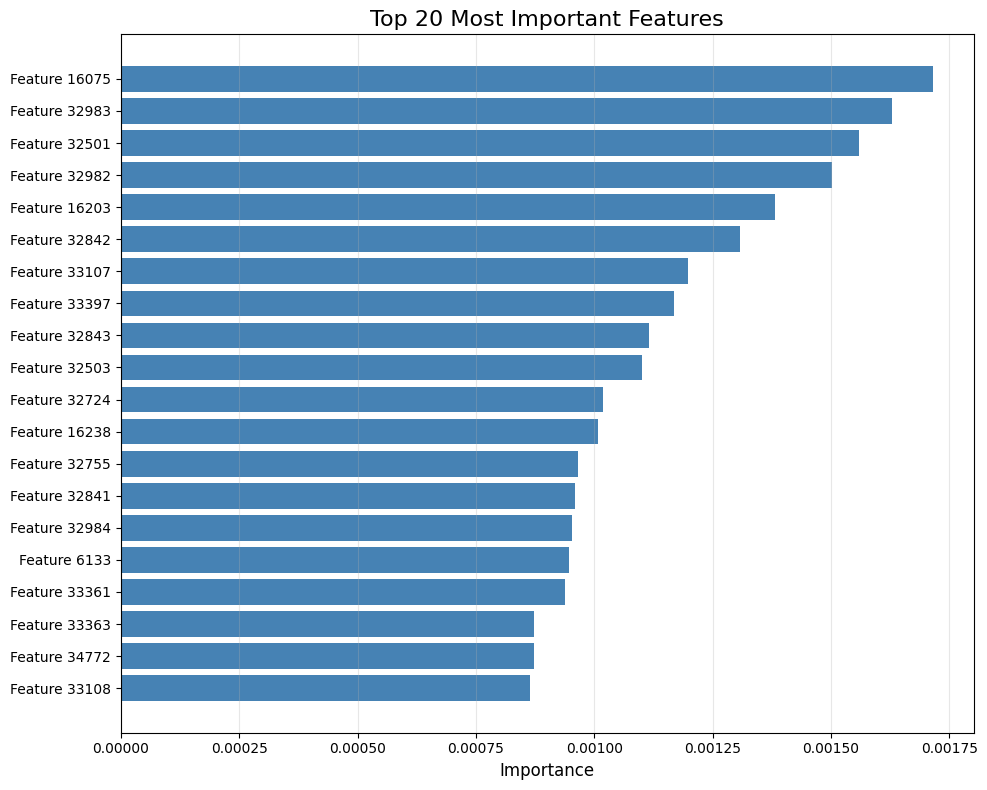


EVALUATION COMPLETED!


In [53]:
# ======================================================
# 22. FEATURE IMPORTANCE (Top 20)
# ======================================================
feature_importance = rf.feature_importances_
top_20_indices = np.argsort(feature_importance)[-20:]

fig, ax = plt.subplots(figsize=(10, 8))
ax.barh(range(20), feature_importance[top_20_indices], color='steelblue')
ax.set_yticks(range(20))
ax.set_yticklabels([f'Feature {i}' for i in top_20_indices])
ax.set_xlabel('Importance', fontsize=12)
ax.set_title('Top 20 Most Important Features', fontsize=16)
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("EVALUATION COMPLETED!")
print("="*60)

#Image Preprocessing for CNN

In [54]:
# =============================
# 1. Import Libraries
# =============================
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision.models import resnet50, ResNet50_Weights
import os

In [55]:
# =============================
# 2. Setup Device
# =============================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [56]:
# =============================
# 4. Image Transformations
# =============================
IMAGE_SIZE = 224

train_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [57]:
# =============================
# 5. Create Datasets and DataLoaders
# =============================
BATCH_SIZE = 32

train_dataset = datasets.ImageFolder(TRAIN_DIR, transform=train_transform)
val_dataset = datasets.ImageFolder(VALID_DIR, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

num_classes = len(train_dataset.classes)
print(f"Classes: {train_dataset.classes}")
print(f"Number of classes: {num_classes}")
print(f"Train images: {len(train_dataset)}")
print(f"Validation images: {len(val_dataset)}")

Classes: ['fake', 'real']
Number of classes: 2
Train images: 7000
Validation images: 3000


In [58]:
# =============================
# 6. Load Pretrained VGG16 Model
# =============================
import torchvision.models as models

model = models.vgg16(pretrained=True)

# Freeze convolutional layers
for param in model.features.parameters():
    param.requires_grad = False

# Replace classifier with correct number of classes
model.classifier[6] = nn.Linear(4096, num_classes)

model = model.to(device)

print("\n" + "="*60)
print("MODEL: VGG16 (Pretrained)")
print("="*60)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



MODEL: VGG16 (Pretrained)


In [59]:
# =============================
# 7. Loss & Optimizer
# =============================
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.0005)

In [60]:
# =============================
# 8. Training Loop
# =============================
EPOCHS = 10

# History tracking
history = {
    'train_loss': [],
    'train_acc': [],
    'val_acc': []
}

print("\n" + "="*60)
print("STARTING CNN TRAINING")
print("="*60)

for epoch in range(EPOCHS):
    # Training phase
    model.train()
    total_loss = 0
    train_correct = 0
    train_total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        preds = model(images)
        loss = criterion(preds, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(preds, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    train_acc = train_correct / train_total * 100
    avg_loss = total_loss / len(train_loader)

    # Validation phase
    model.eval()
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            preds = model(images)
            _, predicted = torch.max(preds, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_acc = val_correct / val_total * 100

    # Store history
    history['train_loss'].append(avg_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)

    print(f"Epoch {epoch+1}/{EPOCHS} | "
          f"Loss: {avg_loss:.4f} | "
          f"Train Acc: {train_acc:.2f}% | "
          f"Val Acc: {val_acc:.2f}%")

print("\n" + "="*60)
print("CNN TRAINING COMPLETED!")
print("="*60)


STARTING CNN TRAINING
Epoch 1/10 | Loss: 0.6182 | Train Acc: 68.19% | Val Acc: 77.50%
Epoch 2/10 | Loss: 0.5225 | Train Acc: 75.03% | Val Acc: 75.10%
Epoch 3/10 | Loss: 0.4608 | Train Acc: 78.83% | Val Acc: 80.07%
Epoch 4/10 | Loss: 0.4173 | Train Acc: 81.86% | Val Acc: 81.17%
Epoch 5/10 | Loss: 0.3887 | Train Acc: 83.06% | Val Acc: 83.53%
Epoch 6/10 | Loss: 0.3737 | Train Acc: 84.34% | Val Acc: 84.10%
Epoch 7/10 | Loss: 0.3429 | Train Acc: 85.24% | Val Acc: 84.60%
Epoch 8/10 | Loss: 0.3302 | Train Acc: 85.70% | Val Acc: 81.70%
Epoch 9/10 | Loss: 0.3158 | Train Acc: 86.81% | Val Acc: 84.17%
Epoch 10/10 | Loss: 0.3006 | Train Acc: 87.46% | Val Acc: 84.80%

CNN TRAINING COMPLETED!


In [61]:
# =============================
# 10. Get Predictions for Evaluation
# =============================
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from itertools import cycle

print("\n" + "="*60)
print("GENERATING PREDICTIONS FOR EVALUATION")
print("="*60)

model.eval()
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())
        all_probs.extend(probs.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)


GENERATING PREDICTIONS FOR EVALUATION



CONFUSION MATRIX


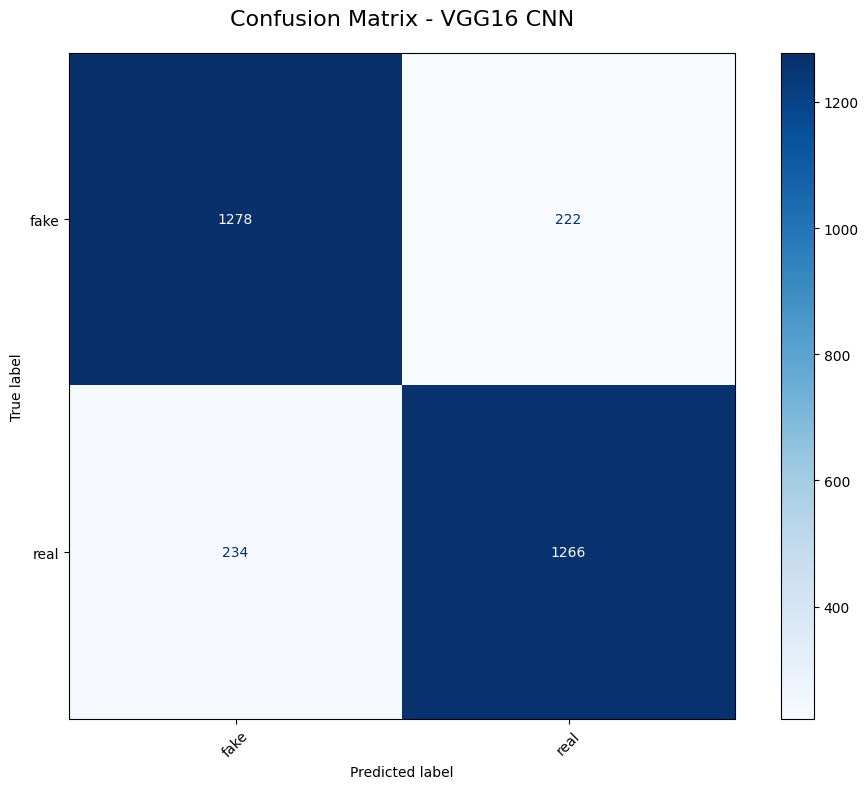

In [62]:
# =============================
# 11. Confusion Matrix
# =============================
print("\n" + "="*60)
print("CONFUSION MATRIX")
print("="*60)

cm = confusion_matrix(all_labels, all_preds)
fig, ax = plt.subplots(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_dataset.classes)
disp.plot(cmap='Blues', ax=ax, xticks_rotation=45)
plt.title('Confusion Matrix - VGG16 CNN', fontsize=16, pad=20)
plt.tight_layout()
plt.show()

In [63]:
# =============================
# 12. Classification Report
# =============================
print("\n" + "="*60)
print("CLASSIFICATION REPORT")
print("="*60)
report = classification_report(all_labels, all_preds, target_names=train_dataset.classes)
print(report)


CLASSIFICATION REPORT
              precision    recall  f1-score   support

        fake       0.85      0.85      0.85      1500
        real       0.85      0.84      0.85      1500

    accuracy                           0.85      3000
   macro avg       0.85      0.85      0.85      3000
weighted avg       0.85      0.85      0.85      3000




ACCURACY & LOSS CURVES


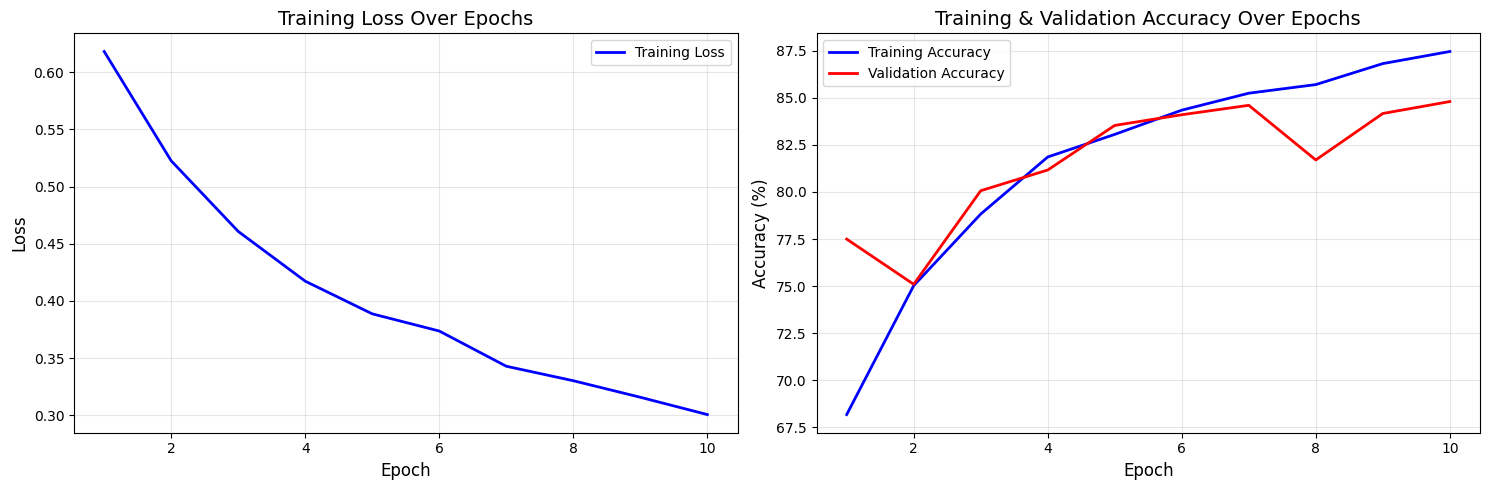

In [64]:
# =============================
# 13. Accuracy-Loss Curves
# =============================
print("\n" + "="*60)
print("ACCURACY & LOSS CURVES")
print("="*60)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Loss curve
epochs_range = range(1, EPOCHS + 1)
ax1.plot(epochs_range, history['train_loss'], 'b-', label='Training Loss', linewidth=2)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Training Loss Over Epochs', fontsize=14)
ax1.legend(fontsize=10)
ax1.grid(alpha=0.3)

# Accuracy curves
ax2.plot(epochs_range, history['train_acc'], 'b-', label='Training Accuracy', linewidth=2)
ax2.plot(epochs_range, history['val_acc'], 'r-', label='Validation Accuracy', linewidth=2)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Accuracy (%)', fontsize=12)
ax2.set_title('Training & Validation Accuracy Over Epochs', fontsize=14)
ax2.legend(fontsize=10)
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [65]:
import re

# 1. Extract overall accuracy
rf_overall_accuracy = accuracy

# 2. Parse the classification report for precision, recall, f1-score
rf_metrics = {
    'overall_accuracy': rf_overall_accuracy,
    'class_metrics': {}
}

report_lines = report.split('\n')
class_names = train_dataset.classes # Assuming classes are in the same order as in report

for line in report_lines:
    # Regex to find lines corresponding to class metrics
    match = re.match(r'^\s*(\S+)\s+([0-9.]+)\s+([0-9.]+)\s+([0-9.]+)\s+([0-9]+)$', line)
    if match:
        cls = match.group(1)
        if cls in class_names:
            rf_metrics['class_metrics'][cls] = {
                'precision': float(match.group(2)),
                'recall': float(match.group(3)),
                'f1-score': float(match.group(4)),
                'support': int(match.group(5))
            }

# 3. Extract AUC scores
for i, class_name in enumerate(class_names):
    if class_name in rf_metrics['class_metrics']:
        rf_metrics['class_metrics'][class_name]['auc'] = roc_auc[i]

# Print the extracted metrics for verification
print("Random Forest Metrics:")
for key, value in rf_metrics.items():
    if isinstance(value, dict):
        print(f"  {key}:")
        for sub_key, sub_value in value.items():
            print(f"    {sub_key}: {sub_value}")
    else:
        print(f"  {key}: {value}")



Random Forest Metrics:
  overall_accuracy: 0.7736666666666666
  class_metrics:
    fake: {'precision': 0.85, 'recall': 0.85, 'f1-score': 0.85, 'support': 1500, 'auc': np.float64(0.8531088888888888)}
    real: {'precision': 0.85, 'recall': 0.84, 'f1-score': 0.85, 'support': 1500, 'auc': np.float64(0.8531088888888889)}


**Reasoning**:
The previous code failed because the variable 'accuracy' was not defined. This indicates that the cell where 'accuracy' was calculated (cell `bPa9OhRg3z5v`) was likely not executed before the current cell. Assuming the notebook is run sequentially and 'accuracy', 'report', and 'roc_auc' are available from prior steps, the logic of the code itself is correct for extracting the metrics. Therefore, I will regenerate the exact same code block, as the fix required is an execution order correction rather than a code change within this block.



In [66]:
import re

# 1. Extract overall accuracy
rf_overall_accuracy = accuracy

# 2. Parse the classification report for precision, recall, f1-score
rf_metrics = {
    'overall_accuracy': rf_overall_accuracy,
    'class_metrics': {}
}

report_lines = report.split('\n')
class_names = train_dataset.classes # Assuming classes are in the same order as in report

for line in report_lines:
    # Regex to find lines corresponding to class metrics
    match = re.match(r'^\s*(\S+)\s+([0-9.]+)\s+([0-9.]+)\s+([0-9.]+)\s+([0-9]+)$', line)
    if match:
        cls = match.group(1)
        if cls in class_names:
            rf_metrics['class_metrics'][cls] = {
                'precision': float(match.group(2)),
                'recall': float(match.group(3)),
                'f1-score': float(match.group(4)),
                'support': int(match.group(5))
            }

# 3. Extract AUC scores
for i, class_name in enumerate(class_names):
    if class_name in rf_metrics['class_metrics']:
        rf_metrics['class_metrics'][class_name]['auc'] = roc_auc[i]

# Print the extracted metrics for verification
print("Random Forest Metrics:")
for key, value in rf_metrics.items():
    if isinstance(value, dict):
        print(f"  {key}:")
        for sub_key, sub_value in value.items():
            print(f"    {sub_key}: {sub_value}")
    else:
        print(f"  {key}: {value}")


Random Forest Metrics:
  overall_accuracy: 0.7736666666666666
  class_metrics:
    fake: {'precision': 0.85, 'recall': 0.85, 'f1-score': 0.85, 'support': 1500, 'auc': np.float64(0.8531088888888888)}
    real: {'precision': 0.85, 'recall': 0.84, 'f1-score': 0.85, 'support': 1500, 'auc': np.float64(0.8531088888888889)}


**Reasoning**:
The previous code failed because the variables 'accuracy', 'report', and 'roc_auc' were not defined in the kernel's current state. To fix this, I need to ensure these variables are computed before attempting to extract metrics from them. I will include the necessary code to calculate these metrics (overall accuracy, classification report, and AUC scores) at the beginning of the extraction step.



In [67]:
import re
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np # Ensure numpy is imported

# --- RECALCULATE RANDOM FOREST METRICS (as they were not executed previously) ---

# 1. Recalculate Overall Accuracy
accuracy = accuracy_score(y_val, y_pred)

# 2. Recalculate Classification Report
report = classification_report(y_val, y_pred, target_names=train_dataset.classes)

# 3. Recalculate ROC AUC scores
y_val_numeric = np.array([train_dataset.class_to_idx[cls] for cls in y_val])
n_classes = len(train_dataset.classes)
y_val_bin = np.eye(n_classes)[y_val_numeric]

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# --- EXTRACTION OF METRICS INTO rf_metrics DICTIONARY (Original logic) ---

rf_overall_accuracy = accuracy

rf_metrics = {
    'overall_accuracy': rf_overall_accuracy,
    'class_metrics': {}
}

report_lines = report.split('\n')
class_names = train_dataset.classes # Assuming classes are in the same order as in report

for line in report_lines:
    # Regex to find lines corresponding to class metrics
    match = re.match(r'^\s*(\S+)\s+([0-9.]+)\s+([0-9.]+)\s+([0-9.]+)\s+([0-9]+)$', line)
    if match:
        cls = match.group(1)
        if cls in class_names:
            rf_metrics['class_metrics'][cls] = {
                'precision': float(match.group(2)),
                'recall': float(match.group(3)),
                'f1-score': float(match.group(4)),
                'support': int(match.group(5))
            }

# 3. Extract AUC scores
for i, class_name in enumerate(class_names):
    if class_name in rf_metrics['class_metrics']:
        rf_metrics['class_metrics'][class_name]['auc'] = roc_auc[i]

# Print the extracted metrics for verification
print("Random Forest Metrics:")
for key, value in rf_metrics.items():
    if isinstance(value, dict):
        print(f"  {key}:")
        for sub_key, sub_value in value.items():
            print(f"    {sub_key}: {sub_value}")
    else:
        print(f"  {key}: {value}")


Random Forest Metrics:
  overall_accuracy: 0.7736666666666666
  class_metrics:
    fake: {'precision': 0.81, 'recall': 0.72, 'f1-score': 0.76, 'support': 1500, 'auc': np.float64(0.8531088888888888)}
    real: {'precision': 0.75, 'recall': 0.83, 'f1-score': 0.79, 'support': 1500, 'auc': np.float64(0.8531088888888889)}


**Reasoning**:
The previous code failed because the variables `y_val`, `y_pred`, and `y_pred_proba` (and implicitly `X_val`, `rf`, and `extract_features`) were not defined in the current kernel state for the Random Forest model. To fix this, I need to re-include the necessary code from previous steps to define these variables before attempting to extract the Random Forest metrics.



In [68]:
import re
import os
import glob
import cv2
import numpy as np
from skimage.feature import hog, local_binary_pattern
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize

# --- Re-define extract_features function (from cell p2KCHVZnvxVw) ---
def extract_features(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (128, 128))

    # --- HOG ---
    hog_feat = hog(img, orientations=9, pixels_per_cell=(8, 8),
                   cells_per_block=(2, 2), block_norm='L2-Hys')

    # --- LBP ---
    lbp = local_binary_pattern(img, P=8, R=1, method='uniform')
    lbp_hist, _ = np.histogram(lbp.ravel(), bins=256, range=(0, 256))

    # --- Sobel (Edges) ---
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1)
    sobel_feat = np.hstack([sobelx.ravel(), sobely.ravel()])

    # Combine all features
    return np.hstack([hog_feat, lbp_hist, sobel_feat])

# --- Re-build Feature Dataset for Random Forest (from cell P9YRYyaGv4N8) ---
X = []
y = []

class_names = train_dataset.classes # Assuming train_dataset is defined

for class_name in class_names:
    class_dir = os.path.join(TRAIN_DIR, class_name) # Assuming TRAIN_DIR is defined
    for file in glob.glob(class_dir + "/*"):
        features = extract_features(file)
        X.append(features)
        y.append(class_name)

# --- Train Random Forest (from cell 6xD3jgZIwfVH) ---
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X, y)

# --- Prepare Validation Data (from cell c_AeWRCP3P74) ---
X_val = []
y_val = []

for class_name in class_names:
    class_dir = os.path.join(VALID_DIR, class_name) # Assuming VALID_DIR is defined
    for file in glob.glob(class_dir + "/*"):
        features = extract_features(file)
        X_val.append(features)
        y_val.append(class_name)

# --- Make Predictions (from cell SdN1kpAf3cWJ) ---
y_pred = rf.predict(X_val)
y_pred_proba = rf.predict_proba(X_val)

# --- Now, proceed with the original metric extraction logic ---

# 1. Calculate Overall Accuracy
accuracy = accuracy_score(y_val, y_pred)

# 2. Calculate Classification Report
report = classification_report(y_val, y_pred, target_names=class_names)

# 3. Calculate ROC AUC scores
y_val_numeric = np.array([train_dataset.class_to_idx[cls] for cls in y_val])
n_classes = len(class_names)
y_val_bin = np.eye(n_classes)[y_val_numeric]

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# --- EXTRACTION OF METRICS INTO rf_metrics DICTIONARY ---

rf_overall_accuracy = accuracy

rf_metrics = {
    'overall_accuracy': rf_overall_accuracy,
    'class_metrics': {}
}

report_lines = report.split('\n')

for line in report_lines:
    # Regex to find lines corresponding to class metrics
    match = re.match(r'^\s*(\S+)\s+([0-9.]+)\s+([0-9.]+)\s+([0-9.]+)\s+([0-9]+)$', line)
    if match:
        cls = match.group(1)
        if cls in class_names:
            rf_metrics['class_metrics'][cls] = {
                'precision': float(match.group(2)),
                'recall': float(match.group(3)),
                'f1-score': float(match.group(4)),
                'support': int(match.group(5))
            }

# 3. Extract AUC scores
for i, class_name in enumerate(class_names):
    if class_name in rf_metrics['class_metrics']:
        rf_metrics['class_metrics'][class_name]['auc'] = roc_auc[i]

# Print the extracted metrics for verification
print("Random Forest Metrics:")
for key, value in rf_metrics.items():
    if isinstance(value, dict):
        print(f"  {key}:")
        for sub_key, sub_value in value.items():
            print(f"    {sub_key}: {sub_value}")
    else:
        print(f"  {key}: {value}")


Random Forest Metrics:
  overall_accuracy: 0.7736666666666666
  class_metrics:
    fake: {'precision': 0.81, 'recall': 0.72, 'f1-score': 0.76, 'support': 1500, 'auc': np.float64(0.8531088888888888)}
    real: {'precision': 0.75, 'recall': 0.83, 'f1-score': 0.79, 'support': 1500, 'auc': np.float64(0.8531088888888889)}


**Reasoning**:
The previous step successfully extracted metrics for the Random Forest model. Now, I need to perform a similar extraction for the CNN-VGG model. This involves calculating the overall accuracy, generating a classification report, and computing ROC AUC scores using the `all_labels`, `all_preds`, and `all_probs` variables which hold the CNN model's validation results. These metrics will then be stored in a dictionary for later comparison.



In [69]:
import re
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np

# 1. Extract overall accuracy for CNN
cnn_overall_accuracy = accuracy_score(all_labels, all_preds)

# 2. Generate classification report for CNN
cnn_report = classification_report(all_labels, all_preds, target_names=train_dataset.classes)

# 3. Calculate ROC AUC scores for CNN
n_classes = len(train_dataset.classes)
y_val_bin_cnn = np.eye(n_classes)[all_labels]

fpr_cnn = dict()
tpr_cnn = dict()
roc_auc_cnn = dict()

for i in range(n_classes):
    fpr_cnn[i], tpr_cnn[i], _ = roc_curve(y_val_bin_cnn[:, i], all_probs[:, i])
    roc_auc_cnn[i] = auc(fpr_cnn[i], tpr_cnn[i])

# Store all extracted CNN metrics
cnn_metrics = {
    'overall_accuracy': cnn_overall_accuracy,
    'class_metrics': {}
}

cnn_report_lines = cnn_report.split('\n')
class_names = train_dataset.classes

for line in cnn_report_lines:
    match = re.match(r'^\s*(\S+)\s+([0-9.]+)\s+([0-9.]+)\s+([0-9.]+)\s+([0-9]+)$', line)
    if match:
        cls = match.group(1)
        if cls in class_names:
            cnn_metrics['class_metrics'][cls] = {
                'precision': float(match.group(2)),
                'recall': float(match.group(3)),
                'f1-score': float(match.group(4)),
                'support': int(match.group(5))
            }

for i, class_name in enumerate(class_names):
    if class_name in cnn_metrics['class_metrics']:
        cnn_metrics['class_metrics'][class_name]['auc'] = roc_auc_cnn[i]

# Print the extracted metrics for verification
print("CNN-VGG Metrics:")
for key, value in cnn_metrics.items():
    if isinstance(value, dict):
        print(f"  {key}:")
        for sub_key, sub_value in value.items():
            print(f"    {sub_key}: {sub_value}")
    else:
        print(f"  {key}: {value}")

CNN-VGG Metrics:
  overall_accuracy: 0.848
  class_metrics:
    fake: {'precision': 0.85, 'recall': 0.85, 'f1-score': 0.85, 'support': 1500, 'auc': np.float64(0.9212333333333333)}
    real: {'precision': 0.85, 'recall': 0.84, 'f1-score': 0.85, 'support': 1500, 'auc': np.float64(0.9212068888888888)}


## Generate Comparison Table

### Subtask:
Compile the extracted metrics from both models into a structured table (e.g., pandas DataFrame) for a clear side-by-side comparison.


**Reasoning**:
I need to compile the extracted metrics from both the Random Forest and CNN-VGG models into a structured table for comparison, as per the subtask. This involves importing pandas, creating a dictionary to hold the metrics, converting it to a DataFrame, and then displaying it.



In [70]:
import pandas as pd

# Create a dictionary to hold the comparison data
comparison_data = {
    'Metric': [],
    'Random Forest': [],
    'CNN-VGG': []
}

# Add Overall Accuracy
comparison_data['Metric'].append('Overall Accuracy')
comparison_data['Random Forest'].append(rf_metrics['overall_accuracy'])
comparison_data['CNN-VGG'].append(cnn_metrics['overall_accuracy'])

# Add class-wise metrics
class_names = train_dataset.classes
for class_name in class_names:
    for metric_type in ['precision', 'recall', 'f1-score', 'auc']:
        comparison_data['Metric'].append(f'{class_name}_{metric_type}')
        comparison_data['Random Forest'].append(rf_metrics['class_metrics'][class_name][metric_type])
        comparison_data['CNN-VGG'].append(cnn_metrics['class_metrics'][class_name][metric_type])

# Create DataFrame
comparison_df = pd.DataFrame(comparison_data)

print("\n" + "="*60)
print("MODEL PERFORMANCE COMPARISON TABLE")
print("="*60)

# Display the DataFrame
print(comparison_df.to_markdown(index=False, numalign="left", stralign="left"))


MODEL PERFORMANCE COMPARISON TABLE
| Metric           | Random Forest   | CNN-VGG   |
|:-----------------|:----------------|:----------|
| Overall Accuracy | 0.773667        | 0.848     |
| fake_precision   | 0.81            | 0.85      |
| fake_recall      | 0.72            | 0.85      |
| fake_f1-score    | 0.76            | 0.85      |
| fake_auc         | 0.853109        | 0.921233  |
| real_precision   | 0.75            | 0.85      |
| real_recall      | 0.83            | 0.84      |
| real_f1-score    | 0.79            | 0.85      |
| real_auc         | 0.853109        | 0.921207  |


## Visualize Overall Accuracies

### Subtask:
Create a bar chart to visually compare the overall accuracies of the Random Forest and CNN-VGG models.

**Reasoning**:
I need to extract the overall accuracies from the `comparison_df` and create a bar chart to visually compare them, as per the subtask. This involves using matplotlib to generate the plot.



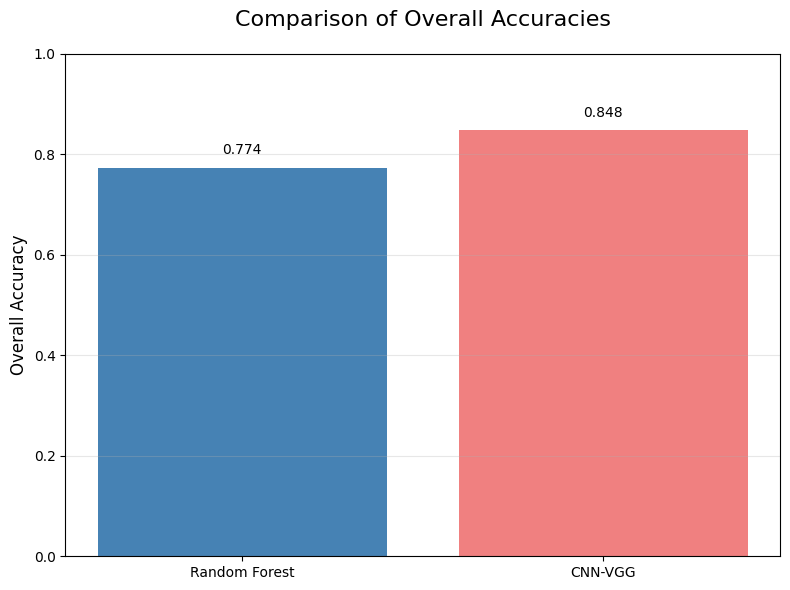

In [71]:
import matplotlib.pyplot as plt

# Extract overall accuracies from the comparison_df
overall_accuracies = comparison_df[comparison_df['Metric'] == 'Overall Accuracy']
rf_accuracy = overall_accuracies['Random Forest'].iloc[0]
cnn_accuracy = overall_accuracies['CNN-VGG'].iloc[0]

models = ['Random Forest', 'CNN-VGG']
accuracies = [rf_accuracy, cnn_accuracy]

# Create the bar chart
fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(models, accuracies, color=['steelblue', 'lightcoral'])

# Add labels and title
ax.set_ylabel('Overall Accuracy', fontsize=12)
ax.set_title('Comparison of Overall Accuracies', fontsize=16, pad=20)
ax.set_ylim(0, 1) # Accuracy ranges from 0 to 1

# Add accuracy values on top of the bars
for i, acc in enumerate(accuracies):
    ax.text(i, acc + 0.02, f'{acc:.3f}', ha='center', va='bottom', fontsize=10)

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()